In [1]:
import os
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.models import load_model
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = "fruits-360-kaggle/Training"
test_path = "fruits-360-kaggle/Test"

target_size = (96, 96)

In [3]:
classes = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3","Apple Granny Smith","Apple Pink Lady","Apple Red 1","Apple Red 2","Apple Red 3","Apple Red Delicious","Apple Red Yellow 1","Apple Red Yellow 2","Apricot","Avocado","Avocado ripe","Banana","Banana Lady Finger","Banana Red","Blueberry","Cactus fruit","Cantaloupe 1","Cantaloupe 2","Carambula","Cherry 1","Cherry 2","Cherry Rainier","Cherry Wax Black","Cherry Wax Red","Cherry Wax Yellow","Chestnut","Clementine","Cocos","Dates","Ginger Root","Granadilla","Grape Blue","Grape Pink","Grape White","Grape White 2","Grape White 3","Grape White 4","Grapefruit Pink","Grapefruit White","Guava","Hazelnut","Huckleberry","Kaki","Kiwi","Kohlrabi","Kumquats","Lemon","Lemon Meyer","Limes","Lychee","Mandarine","Mango","Mango Red","Mangostan","Maracuja","Melon Piel de Sapo","Mulberry","Nectarine","Nectarine Flat","Nut Forest","Nut Pecan","Onion Red","Onion Red Peeled","Onion White","Orange","Papaya","Passion Fruit","Peach","Peach 2","Peach Flat","Pear","Pear Abate","Pear Kaiser","Pear Monster","Pear Red","Pear Williams","Pepino","Pepper Green","Pepper Red","Pepper Yellow","Physalis","Physalis with Husk","Pineapple","Pineapple Mini","Pitahaya Red","Plum","Plum 2","Plum 3","Pomegranate","Pomelo Sweetie","Potato Red Washed","Potato White","Quince","Rambutan","Raspberry","Redcurrant","Salak","Strawberry","Strawberry Wedge","Tamarillo","Tangelo","Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Cherry Red","Tomato Maroon","Tomato Yellow","Walnut"]

# Imprimindo algumas imagens da base de treinamento

In [4]:
sample_train_datagen = ImageDataGenerator(rescale=1./255)

sample_train_generator = sample_train_datagen.flow_from_directory(directory = train_path,
                                                                  target_size=(100, 100),
                                                                  batch_size=64,
                                                                  class_mode="sparse")

sample_test_datagen = ImageDataGenerator(rescale=1./255)

sample_test_generator = sample_test_datagen.flow_from_directory(directory = test_path,
                                                                target_size=(100, 100),
                                                                batch_size=64,
                                                                class_mode="sparse")

Found 57276 images belonging to 114 classes.
Found 19548 images belonging to 114 classes.


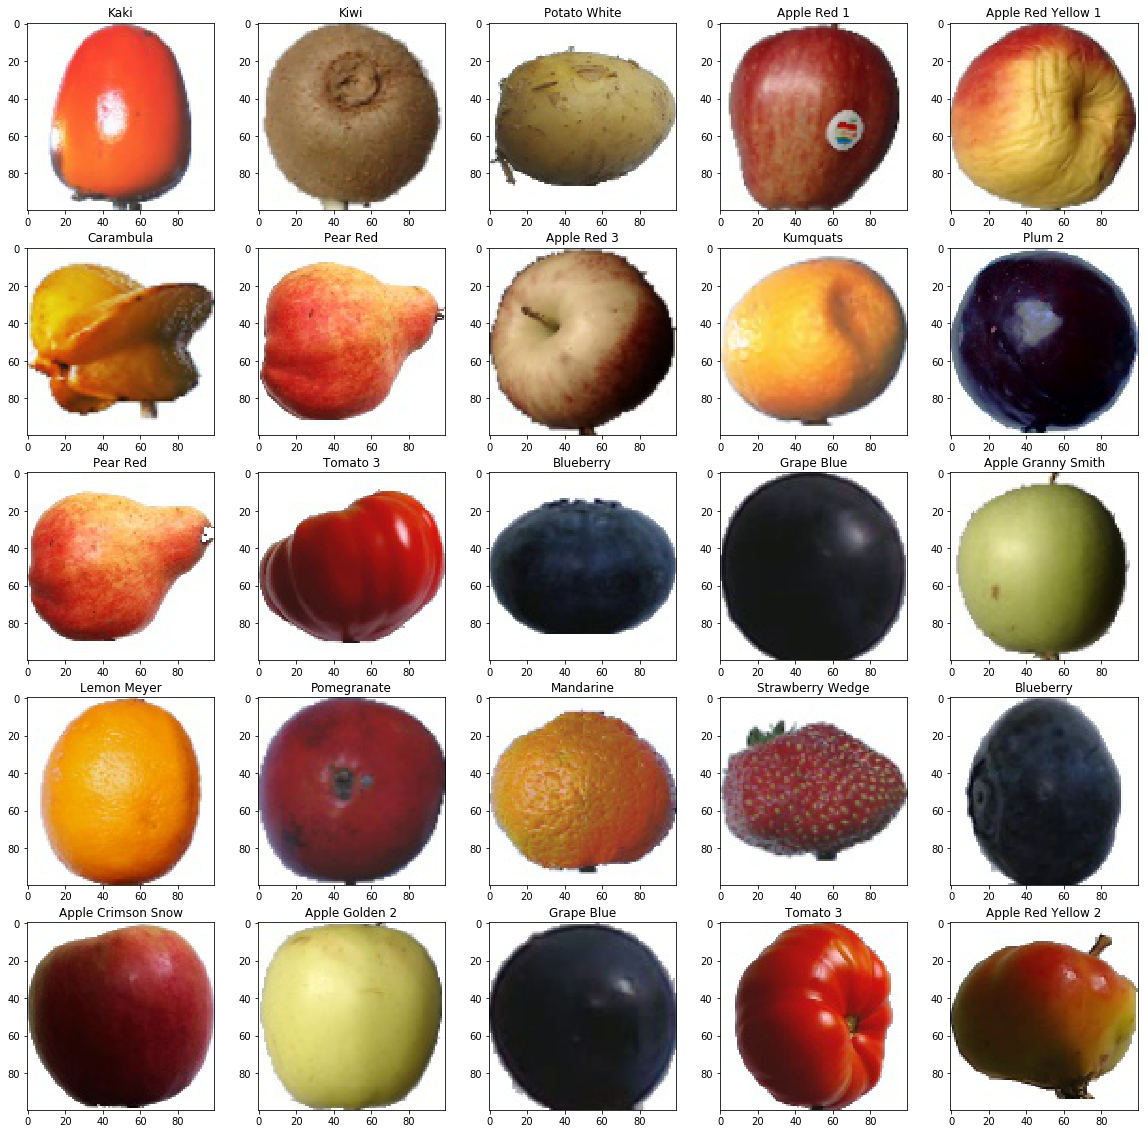

In [5]:
x_sample, y_sample = sample_train_generator.next()
plt.rcParams['figure.figsize'] = (20,20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

# Visualizando a frequência das classes

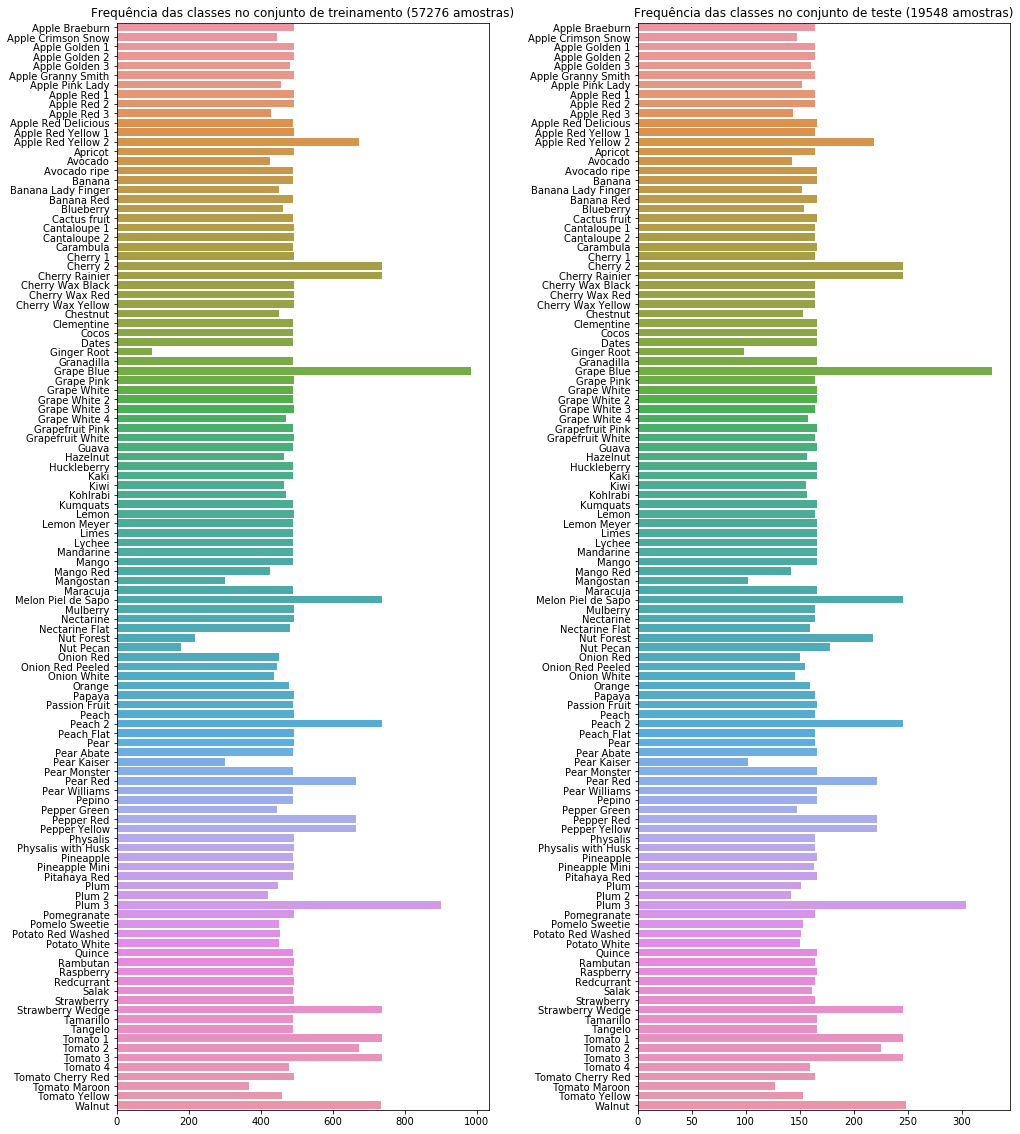

In [6]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequência das classes no conjunto de treinamento (%i amostras)' % len(sample_train_generator.labels))
_, counts = np.unique(sample_train_generator.labels, return_counts=True)
sns.barplot(counts, classes)

plt.subplot(122)
plt.title('Frequência das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes)

# Carregando as imagens da base treino e testes
##Utilizaremos 20% da base de treinamento para validação

In [7]:
batch_size = 64

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(directory = train_path,
                                                         target_size = target_size,
                                                         batch_size = batch_size,
                                                         shuffle = False,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                  target_size = target_size,
                                                  batch_size = batch_size,
                                                  shuffle = False,
                                                  class_mode = "categorical")

Found 45852 images belonging to 114 classes.
Found 11424 images belonging to 114 classes.
Found 19548 images belonging to 114 classes.


# Parâmetros para treinamento, validação e teste

In [8]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

input_shape = [96, 96, 3]

device = '/gpu:0'

batch_size = 64

epochs = 50

train_steps = train_generator.samples // batch_size + 1

validation_steps = validation_generator.samples // batch_size + 1

test_steps = test_generator.samples // batch_size + 1

patience = epochs // 3

Instructions for updating:
Colocations handled automatically by placer.


# Funções de apoio

In [9]:
df_resultado = pd.DataFrame(columns=["Rede", "train_acc", "val_acc"])

acuracias = {}

In [10]:
def consultar_lr_scheduler(epoch, current_lr):
    epoch = epoch + 1
    lr = ((1.0 / epoch) * 0.05) * 0.005
    return lr

In [11]:
def salvar_resultado(rede, train_acc, val_acc, df):
    df = df.append({"Rede" : rede,
                    "train_acc" : train_acc,
                    "val_acc" : val_acc}, ignore_index = True)
    return df

In [12]:
def treinar_modelo(device, model, train_generator, train_steps, epochs, validation_generator, patience):
    with tf.device(device):
        History = model.fit_generator(generator = train_generator,
                                      steps_per_epoch = train_steps,
                                      epochs = epochs,
                                      verbose = 1,
                                      validation_data = validation_generator,
                                      validation_steps = validation_steps,
                                      callbacks=[callbacks.TerminateOnNaN(),
                                                 callbacks.LearningRateScheduler(consultar_lr_scheduler, 1),
                                                 callbacks.ReduceLROnPlateau(patience = patience),
                                                 callbacks.EarlyStopping(patience = patience,
                                                                         restore_best_weights = True,
                                                                         verbose = 1)])
        return pd.DataFrame(History.history)

In [13]:
def imprimir_resultado_treinamento(history):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    sns.lineplot(data=history[['loss', 'val_loss']])
    
    plt.subplot(122)
    sns.lineplot(data=history[['acc', 'val_acc']]);

In [14]:
def avaliar_modelo(model, generator, steps):
    score = model.evaluate_generator(generator = generator,
                                     steps = steps)
    
    return score

In [15]:
def fazer_predicao(model, generator, steps):
    generator.reset()
    
    probabilities = model.predict_generator(generator = generator,
                                            steps = steps)
    
    predictions = np.argmax(probabilities, axis=1)
    
    return predictions

In [16]:
def imprimir_matriz_confusao(predictions, generator_classes):
    c = metrics.confusion_matrix(generator_classes, predictions)

    r = c / c.sum(axis=1).reshape(-1, 1)
    
    plt.figure(figsize=(16, 14))
    ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=classes, yticklabels=classes);
    
    return r.diagonal()

# Rede *Homemade* - CNN

## Definindo a rede

In [17]:
home_made = Sequential()

home_made.add(Conv2D(filters = 10,
                     kernel_size = [3, 3],
                     name = "conv_1",
                     activation = "relu",
                     input_shape = input_shape))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_1"))

home_made.add(Conv2D(filters = 20,
                     kernel_size = [3, 3],
                     name = "conv_2",
                     activation = "relu"))

home_made.add(Dropout(rate = 0.5,
                      name = "do_1"))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_2"))

home_made.add(Flatten())

home_made.add(Dense(units = len(classes),
                    name = "dense_1",
                    activation = "softmax"))

home_made.compile(optimizer = rms,
                  loss = "categorical_crossentropy",
                  metrics=["accuracy"])

home_made.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 94, 94, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 47, 47, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 45, 45, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 45, 45, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 22, 22, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9680)              0         
___________________________

## Treinando o modelo

In [18]:
history = treinar_modelo(device, home_made, train_generator, train_steps, epochs, validation_generator, patience)

home_made.save("home_made_epoch_" + str(epochs) + ".h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 169s 236ms/step - loss: 0.8278 - acc: 0.8045 - val_loss: 0.6029 - val_acc: 0.8534
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 136s 190ms/step - loss: 0.0350 - acc: 0.9925 - val_loss: 0.3847 - val_acc: 0.9010 1:39 - loss: 0.0586 - acc: 0.990 - ETA: 1:39 - los - ETA: 1:40 - loss: 0.0560 - acc: 0.9 - ETA: 1:40 - loss: 0.0551 - acc: 0.99 - ETA: 1:40 - loss: 0.0563 - acc: - - ETA: 1:36 - loss: 0.0555 -  - ETA: 1:34 - loss: - ETA: 1:31 - loss: 0.0532 - acc - ETA: 1: - ETA: 1:26 - loss: 0.051 - ETA: 1:24 - loss: 0.0510 - acc: 0.9 - ET - ETA: 1:17 - los - ETA: 1: - ETA: 1:02 - loss: 0.0448 - acc: 0.990 - ETA: 1:02 - loss: 0.0448 - acc: 0 - ETA: 1:01 - loss: 0.0447 - acc: 0.990 - ETA: 1:01 - loss: 0 - ETA: 59s - loss: 0.0440 - a - ETA: 58s - loss

717/717 [==============================] - 137s 191ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.3539 - val_acc: 0.9231 - acc: 0.999 - ETA: 1:40 - loss: 0.0026 - ac - ETA: 1:40 - loss: 0. - ETA: 1:39 - loss: 0.0022 - ETA: 1:38 - loss: 0.0024 - acc: 0.999 - ETA: 1:38 - loss: 0.0024 - acc: 0.99 - ETA: 1:38 - loss: 0.002 - ETA: 1:36 - loss: 0.0023 - - ETA: 1:35 - loss: 0.0022 -  - ETA: 1:33 - loss: 0.0021 - ac - ETA: 1:32 - loss: 0.002 - ETA:  - ETA: 1:25 - loss - ETA: 1:22 - loss: 0.0020 - acc: 0. - ETA: 1:21 - loss: 0.0020 - acc: 0.999 - ETA: - ETA: 1:15 - loss: 0.0021 - acc - ETA: 1:14 - loss: 0.0020 - acc: 0 - ETA: 1:13 - los - ETA: 1:10 - loss: 0.0020  - ETA: 1:07 - loss: 0.0020 - - ETA: 1:05 - loss: 0.002 - ETA: 1:03 - loss: 0.0020 - acc: 0.999 - ETA: 1:03 - loss: 0.0020 - acc:  - ETA: 1:02 - l - ETA: 58s - loss: 0.0019 - a - ETA: 58s -  - ETA: 55s - loss: 0.0019 - ETA: 54s - loss: 0.0019 - ETA: 53s - loss: 0. - ETA: 45s - loss: 0.0018 - acc: 0. - ETA: 44s - loss: 0.0018 - acc:

717/717 [==============================] - 137s 191ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.3816 - val_acc: 0.9208TA: 1:35 - loss: 4.0719e-04 - a - ETA: 1:38 - loss: 6.9261e-04 - acc: 1. - ETA: 1:39 - loss: 6.6435e-04 - ac - ETA: 1:40 - loss: - ETA: 1:40 - los - ETA: 1:38 - loss: 0 - ETA: 1:36 - loss: 0.0012 - a - ET - ETA: 1:30 - loss: 0.0011 - acc:  - ETA: 1:30 - loss: 0.0010 - acc: 0.9 - ETA: 1:29 - loss: 0.0010 - acc: 0.999 - ETA: 1:29 - ETA: 1:25 - loss: 9.5857e-04 - acc: 0.999 - ETA: 1:25 - loss: 9.5430e-04 - acc - ETA: 1:23 - loss: 9.3157e-04 - acc: 0.999 - ETA: 1:23 - los - ETA: 1:19 - loss: 9.1192e-04 - - ETA: 1:17 - loss: 9.1497e-0 - ETA: 1:07 - loss: 8.7736e-04 - acc: 1.00 - ETA: 1:07 - loss: 8.7307e-04 - acc: 1. - ETA: 1:06 - loss: 8.7065e-04 - a - ETA: 1:05 - loss: 8.6202e-04 - ac - ETA: 1:03 - loss: 8.6693e-04 - acc: - ETA: 1:0 - ETA: 22s - loss: 0.0012 - ETA: 21s - loss: 0.0012 - a - ETA: 20s - loss: 0.0012 - ETA: 19s - loss - - ETA: 14s - loss: 0. - ETA: 12s -

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105023). Check your callbacks.
  % delta_t_median)


717/717 [==============================] - 138s 193ms/step - loss: 9.8491e-04 - acc: 0.9998 - val_loss: 0.3658 - val_acc: 0.9245A: 1:22 - loss: 9.4512e-0 - ETA: 1:20 - loss: 9.1425e-04 - acc: 0.99 - ETA: 1:19 - loss: 9.0795e-04 - a - ETA: 1:18 - loss: 8.8616e-04 - acc: - ETA: 1:17 - loss: 8.8242e-04 - ETA: 1:14 - loss: 9 - ETA: 1:11 - loss:  - ETA: 1:07 - loss: 8.6289e-04 - acc: 0. - ETA: 1:06 - loss: 8.5759e-04 -  - ETA: 1:04 - loss - ETA: 1:00 - loss - ETA: 54s - loss: 8.7465e-04 - acc: 0. - ETA: 53s - loss: 8.7155e-04 - - ETA: 52s - loss: 8.6118e- - ETA: 51s - loss: 8.5854e-04 - acc: 0. - ETA: 51s - loss: 8.5489e-04 - acc: 0.99 - ETA: 50s - loss:  - ETA: 45s - loss: 8.2747e-04 - a - ETA: 44s - loss: 8.2160e-04 - acc - ETA: 43s - loss: 8.1725e-04 - acc: 0. - ETA: 43s - lo - ETA: 29s - loss - ETA: 27s - loss: 7.9103e-04 - acc: 0.99 - E - ETA: 23s - loss: 9.2144e-04 - acc: 0. - ETA: 23s - loss: 9.1936e-04 - acc: 0.99 - ETA: 22s - loss: 9.1788e-04 - ETA: 21s - loss: 9.1603 - ETA: 20s - 

717/717 [==============================] - 138s 192ms/step - loss: 6.7831e-04 - acc: 0.9998 - val_loss: 0.3828 - val_acc: 0.9194: 1:39 - loss: 3. - ETA: 1:42 - loss: 8.3554e-04 - acc: 0.999 - ETA: 1:42 - loss: 8.2575e-04 - acc: 0 - ETA: 1:41 - loss: 7.8397e-04 - acc: 0.9 - ETA: 1:41 - loss: 7.5592e-04 - acc: - ETA: 1:41 - loss: 0.0010 - ac - ETA:  - ETA: 1:37 - loss: 7.324 - ETA: 1:34 - loss: 7.0312e-04 - acc: 0 - ETA: 1:34 - loss: 6.8908e - ETA: 1:31 - loss: 6.630 - ETA: 1:28 - loss: 6.3107e-04 - a - ETA: 1:27 - loss: 6.6172e-04 - - ETA: 1:25 - loss: 6.706 - ETA: 1:22 - loss: 6.5102e-04 - acc: 0.9 - ETA: 1:22 - loss: 6.4746e-04 - acc:  - ETA: 1:21 - loss: 6.3615e-04 - acc: 0. - ETA: 1:20 - loss: 6.2922e-04 - acc: 0 - ETA: - ETA: 1:13 - loss: 6.5213e-04 - acc: 0.99 - ETA: 1:13 - loss: 6.4823e-04 - acc: 0.999 - ETA: 1:12 - loss: 6.4814e-04 - ETA: 1:10 - loss: 7.2292e-04 - acc: 0 - ETA: 1:09 - loss: 7.1323e-04 - a - ETA: 1:08 - loss: 7.0215e-04 - acc: 0. - ETA: 1:07 - loss: 6.9754e-04 - 

## Imprimindo resultado do treinamento

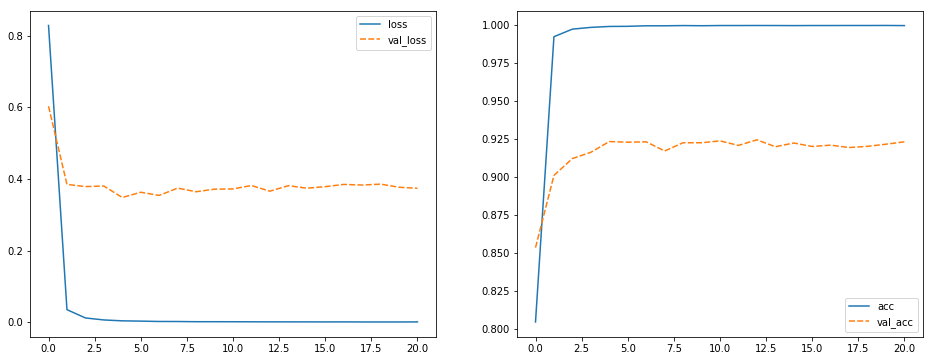

In [19]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

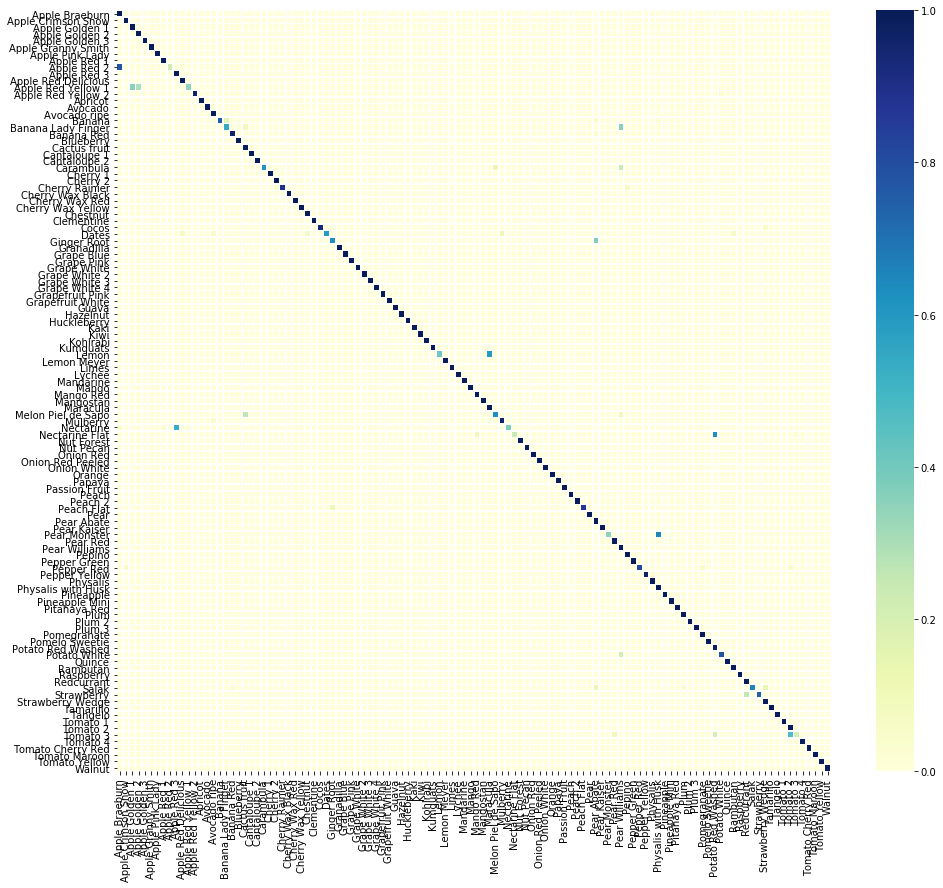

In [20]:
if os.path.isfile("home_made_epoch_" + str(epochs) + ".h5"):
    home_made = load_model("home_made_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(home_made, train_generator, train_steps)


predictions_validation = fazer_predicao(home_made, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "Homemade",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["homemade_validation"] = diagonal

### Acurácia por Classe

In [21]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [22]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Apple Braeburn,1.0
Kohlrabi,1.0
Pear Kaiser,1.0
Pear Abate,1.0
Pear,1.0
Peach 2,1.0
Peach,1.0
Passion Fruit,1.0
Papaya,1.0
Orange,1.0


#### 10 piores

In [23]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Tomato 3,0.210884
Apple Red 2,0.224490
Nectarine Flat,0.239583
Apple Red Yellow 1,0.346939
Pear Monster,0.346939
Nectarine,0.377551
Lemon,0.408163
Banana Lady Finger,0.544444
Dates,0.591837
Carambula,0.612245


# ResNet50 - Transfer Learning

## Feature Extraction

In [24]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

ResNet50_model = ResNet50(input_shape = input_shape,
                          weights = "imagenet",
                          include_top = False)

for layer in ResNet50_model.layers:
    layer.trainable = False

output = ResNet50_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(units = len(classes),
               activation ='softmax',
               name = 'saida_mdc')(output)

ResNet50_model = Model(inputs = ResNet50_model.input,
                       outputs = output)

ResNet50_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet50_model.summary()

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Treinando o modelo

In [25]:
history = treinar_modelo(device, ResNet50_model, train_generator, train_steps, epochs, validation_generator, patience)

ResNet50_model.save("ResNet50_fe_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 140s 196ms/step - loss: 0.1032 - acc: 0.9797 - val_loss: 5.2168 - val_acc: 0.00842 - ETA: 1:55 - loss: 0.8736 - acc: 0. - ETA: - ETA: 1:39 - loss: 0.4571 - acc: - ETA: 1:38 - loss: 0.4380 -  - ETA: 1:36 - loss: 0.4112 - acc: 0.91 - ETA: 1:35 - loss: 0 - ETA: 1:32 - loss - ETA: 1:28 - loss: 0.3322 - acc: 0.934 - ETA: 1:27 - loss: 0.3307 - ETA: 1:25 - los - ETA: 1:2 - ETA: 1:15 - loss: 0.2549 - ac - ETA: 1:14 - loss: 0.2472 - acc: 0.9 - ETA: 1:13 - loss: 0.2 - ETA: 1:10 - loss: 0.2318 - ETA: 1:07 - loss: 0.2221 -  - ETA: 1:05 - loss: 0.2150 - acc: 0.957 - ETA: 1:05 - loss: 0.2144 - acc: 0. - ETA: 1:05 - loss: 0.2124 - acc: 0. - ETA: 1:04 - loss: 0.2100 - ac - ETA: 1:02 - loss: 0.2048 - acc: 0.9 - ETA: 1:02 - loss: 0.2031 - - - ETA: 56s -  - ETA: 54s - loss: 0.1807 - acc - ETA: 53s - loss: 0.1790 - a - ETA: 52s - loss: 0.1768 - acc: 0. - E - ETA: 45s - loss: 0.1615 -

717/717 [==============================] - 141s 196ms/step - loss: 7.4914e-07 - acc: 1.0000 - val_loss: 5.2564 - val_acc: 0.0086 ETA: 1:35 - loss: 3.1051e-07 - acc: 1.00 - ETA: 1:35 - loss: 3.0466e-07 - acc: 1.000 - ETA: 1:36 - loss: 3.0473e-07 - acc: 1. - ETA: 1:36 - lo - ETA: 1:38 - loss: 2.9510e-07 - acc - ETA: 1:38 - loss: 2.9796e-07 - acc: 1.00 - ETA: 1:38 - loss: 2.9958e-07 - acc: 1.0 - ETA: 1:38 - loss: - ETA: 1:3 - ETA: 1:32 - loss - ETA: 1:28 - loss: 1.0915e-06 - ETA: 1:26 - loss: 1.0289e-06 -  - ETA: 1:25 - loss: 9.9652e-07 - acc: - E - ETA: 1:17 - loss: 8.8196e-07 - acc: 1.0 - ETA: 1:17 - loss: 8.7418e-07 - acc: 1.00 - ETA: 1:17 - loss: 8.74 - ETA: 1:14 - loss: 8.4709e-07 - acc: 1 - ETA: 1:13 - loss: 8.5449e-07 - acc: 1.00 - ETA: 1:12 - loss: 8.5203e-07 - acc: 1. - ETA: 1:12 - loss: 8.4379e-07 - acc: - ETA: 1:11 - loss: 8.3210e-07 - a - ETA: 1:09 - loss: 8.4750e-07 -  - ETA: 1:07 - loss: 8.2958e-07 - acc:  - ETA: 1:06 - loss: 8.2041e-07 - acc: 1 - ETA: 1:05 - loss: 8.1054e-0

717/717 [==============================] - 140s 195ms/step - loss: 4.3426e-07 - acc: 1.0000 - val_loss: 5.2618 - val_acc: 0.0084: 1:34 - loss: 2.9951e-07 -  - ETA: 1:37 - loss: 2.81 - ETA: 1:38 - loss: 2.8404e-07 - acc:  - ETA: 1:38 - loss: 2.8056e-07 - acc: 1.000 - ETA: 1:38 - loss: 2.7920e-07 - acc - ETA: 1:38 - loss: 2.6736e-07 - a - ETA: 1:38 - loss: 3.1728e-07 - ac - ETA: 1:37 - loss: 6.7421e-07 - acc: 1.000 - ETA: 1:37 - loss: 6.7029e-07 -  - ETA: 1:36 -  - ETA: 1:26 - loss: 5.733 - ETA: 1:24 - loss: 5.4076e-07 - acc: 1 - ETA: 1:23 - loss: 5.3323e-07 - acc: 1.00 - ETA: 1:23 - loss: 5.3030e-07 - acc:  - ETA: 1:22 - loss: 5.2 - ETA: 1:18 - loss: 5.1334e-07 - acc: 1.00 - ETA: 1:18 - loss: 5.1041e-07 - acc: 1.00 - ETA: 1:18 - loss: 5.0745e-07  - ETA: 1:16 - loss: 4.9700e-07 - acc: 1.000 - ETA: 1:15 - l - ETA: 1:11 - los - ETA: 1:06 - loss: 4.4373e-07 - acc: 1.000 - ETA: 1:06 - loss: 4.4304e-07 - acc: 1 - ETA: 1:05 - loss: 4.46 - ETA: 1:02 - loss: - ETA: 59s - loss: 4.1699e-07 - acc: 

717/717 [==============================] - 140s 195ms/step - loss: 2.6148e-07 - acc: 1.0000 - val_loss: 5.2653 - val_acc: 0.0085: 2.0247e-07 - acc: 1.00 - ETA: 1:37 - loss: 2.0289e-07 - acc: 1.00 - ETA: 1:37 - loss: 2.0138e-07  - ETA: 1:36 - loss: 1.9904e-07 - acc: 1.000 - ETA: 1:36 - loss: 1.9839e-07 - acc: 1.000 - ETA: 1:36 - los - ETA: 1:33 - loss: 2.0802e-07 - acc: 1 - ETA: 1:32 - loss: 2.0915e-07 -  - ETA: 1:31 - loss: 2.2446e-07 - acc:  - ETA: 1:30 - loss: 2.2597e-07  - ETA: 1:28 - loss: 2.2408e - ETA: 1:26 - loss: 2.2388e-07 - acc: 1.000 - ETA: 1:26 - loss:  - ETA: 1:22 - loss: 2.2242e-07 - - ETA: 1:20 - loss: 2.2206e-07 - acc: 1. - ETA: 1:20 - loss: 2.2125e-07 - acc: 1.00 - ETA: 1:19 - loss: 2.2137e-07 - acc: 1.000 - ETA: 1:19 - loss: 2.2097e-07 - - ETA: 1:17 - loss: 2.1746e-07 - acc: 1.000 - ETA: 1:17 - loss: 2.1717e-07 - acc: 1.0 - ETA: 1:17 - loss: - ETA: 1:13 - loss: 2.1161e-07 - ETA: 1:10 - loss: 2.1490e-07 - acc: 1.000 - ETA: 1:10 - loss: 2.1472e-07 - acc: 1.00 - ETA: 1:1

### Imprimindo resultado do treinamento

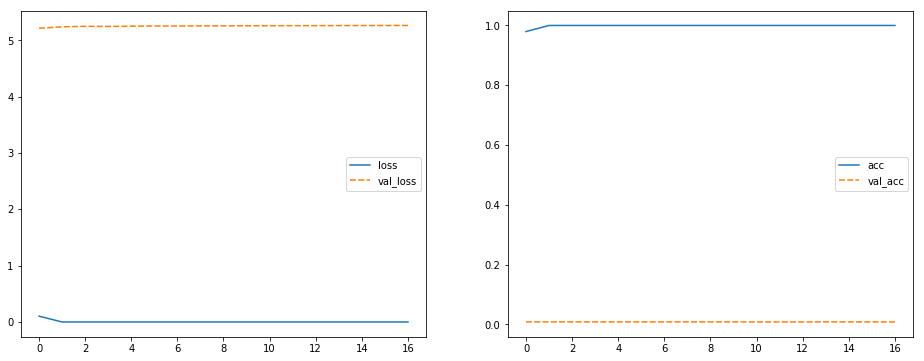

In [26]:
imprimir_resultado_treinamento(history)

In [27]:
#model_feat = Model(inputs = ResNet50_model.input, outputs = ResNet50_model.get_layer('saida_mdc').output)

In [28]:
#feat_train = model_feat.predict_generator(train_generator)

In [29]:
#feat_val = model_feat.predict_generator(validation_generator)

In [30]:
#from sklearn.svm import SVC
#svm = SVC(kernel='rbf')

In [31]:
#svm.fit(feat_val, validation_generator.classes)

In [32]:
#svm.score(feat_val, validation_generator.classes)

## Matriz de Confusão & Acurácia

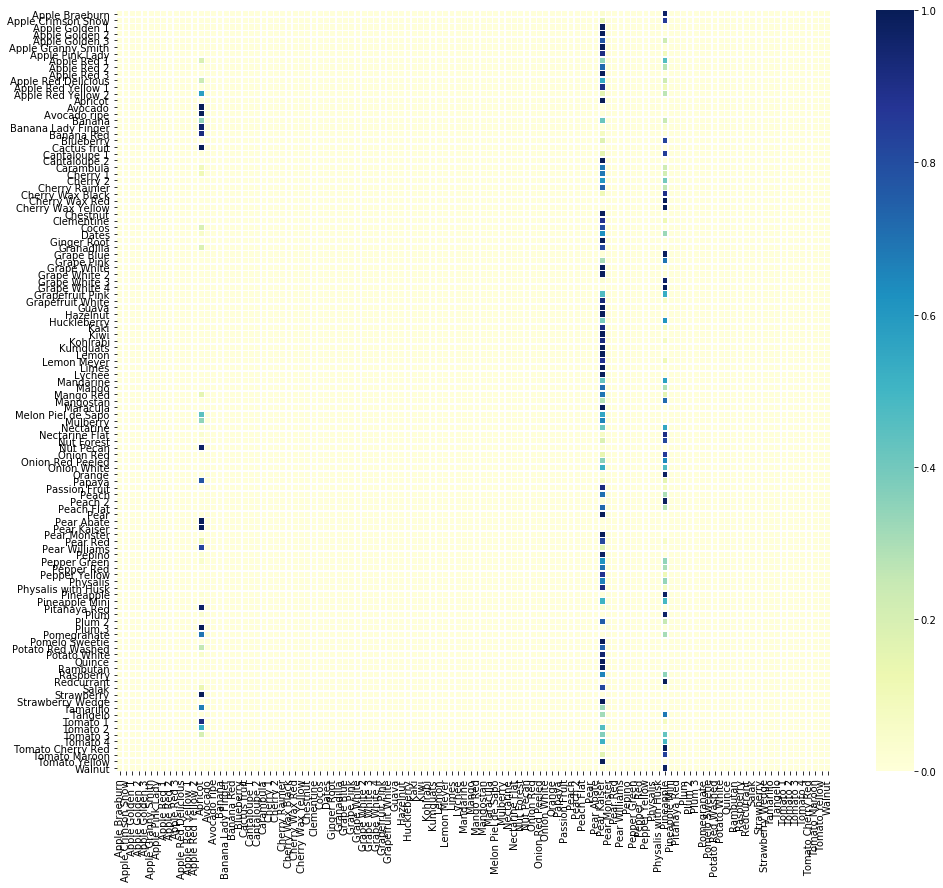

In [33]:
if os.path.isfile("ResNet50_fe_epoch_" + str(epochs) + ".h5"):
    ResNet50_model = load_model("ResNet50_fe_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(ResNet50_model, train_generator, train_steps)


predictions_validation = fazer_predicao(ResNet50_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "ResNet50 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["ResNet50_fe_validation"] = diagonal

### Acurácia por Classe

In [34]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [35]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Pineapple,0.979592
Apple Braeburn,0.000000
Peach,0.000000
Pepper Red,0.000000
Pepper Green,0.000000
Pepino,0.000000
Pear Williams,0.000000
Pear Red,0.000000
Pear Monster,0.000000
Pear Kaiser,0.000000


#### 10 piores

In [36]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Braeburn,0.0
Pepino,0.0
Pear Williams,0.0
Pear Red,0.0
Pear Monster,0.0
Pear Kaiser,0.0
Pear Abate,0.0
Pear,0.0
Peach Flat,0.0
Peach 2,0.0


## Fine Tuning

In [37]:
for layer in ResNet50_model.layers:
    layer.trainable = True

ResNet50_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Treinando o modelo

In [38]:
history = treinar_modelo(device, ResNet50_model, train_generator, train_steps, epochs, validation_generator, patience)

ResNet50_model.save("ResNet50_ft_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 222s 310ms/step - loss: 0.4698 - acc: 0.9607 - val_loss: 1.7800 - val_acc: 0.8550
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 212s 296ms/step - loss: 0.1869 - acc: 0.9874 - val_loss: 0.1299 - val_acc: 0.9727
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 215s 300ms/step - loss: 0.1062 - acc: 0.9933 - val_loss: 0.0630 - val_acc: 0.9844
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 217s 303ms/step - loss: 0.0301 - acc: 0.9978 - val_loss: 0.0800 - val_acc: 0.9825
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5.000000000000001e-05.
717/717 [==============================] - 221s 308ms/step - loss

### Imprimindo resultado do treinamento

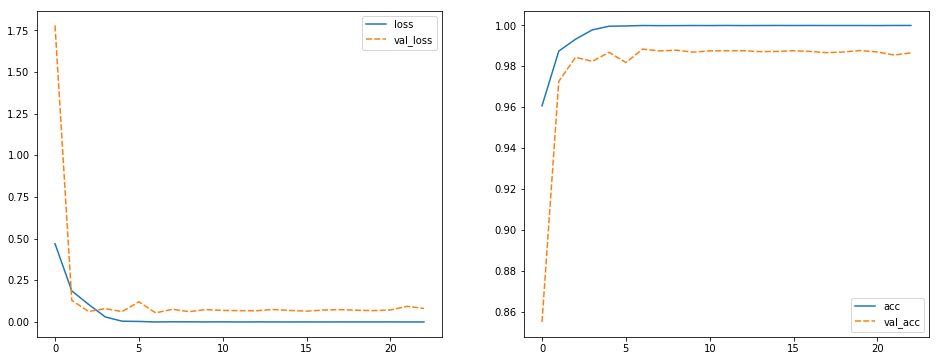

In [39]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

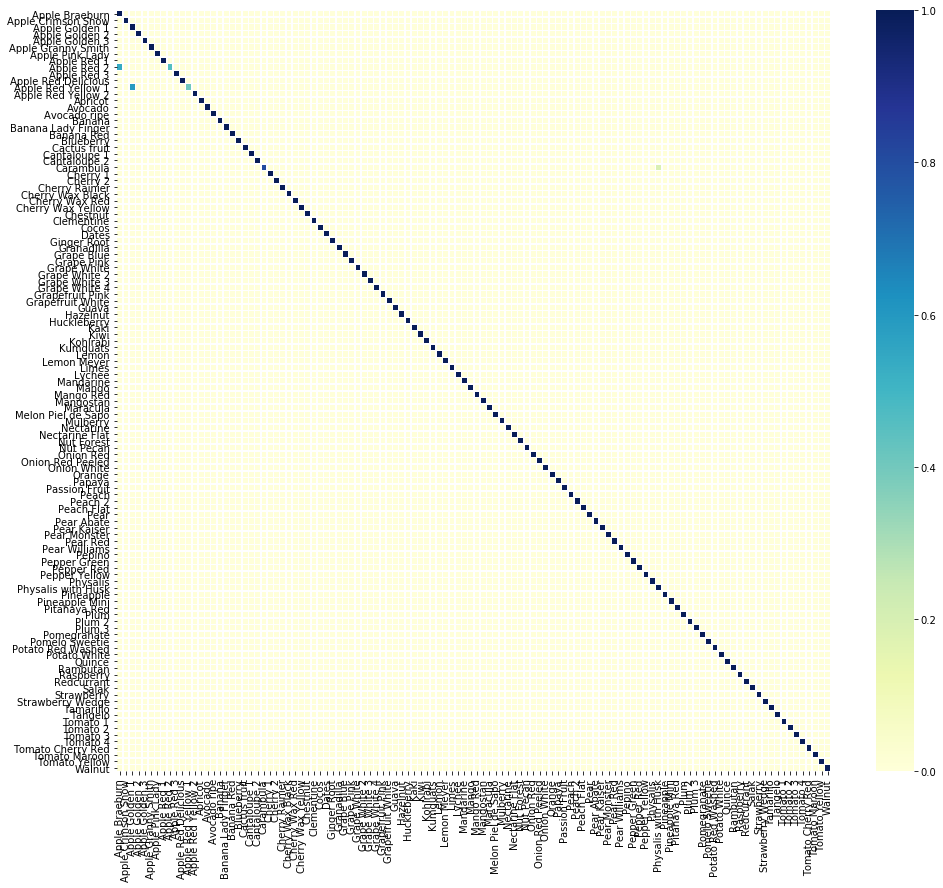

In [40]:
if os.path.isfile("ResNet50_ft_epoch_" + str(epochs) + ".h5"):
    ResNet50_model = load_model("ResNet50_ft_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(ResNet50_model, train_generator, train_steps)


predictions_validation = fazer_predicao(ResNet50_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "ResNet50 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["ResNet50_ft_validation"] = diagonal

### Acurácia por Classe

In [41]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [42]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Apple Braeburn,1.0
Apple Crimson Snow,1.0
Pepper Red,1.0
Pepper Green,1.0
Pepino,1.0
Pear Williams,1.0
Pear Red,1.0
Pear Monster,1.0
Pear Kaiser,1.0
Pear Abate,1.0


#### 10 piores

In [43]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Red Yellow 1,0.408163
Apple Red 2,0.459184
Carambula,0.806122
Tomato 2,0.992537
Grape Blue,0.994898
Apple Braeburn,1.000000
Pepper Green,1.000000
Pepino,1.000000
Pear Williams,1.000000
Pear Red,1.000000


# VGG16 - Transfer Learning

## Feature Extraction

In [44]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

VGG16_model = VGG16(input_shape = input_shape,
                    weights = "imagenet",
                    include_top = False)

for layer in VGG16_model.layers:
    layer.trainable = False

output = VGG16_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(units = len(classes),
               activation ='softmax',
               name = 'saida_mdc')(output)

VGG16_model = Model(inputs = VGG16_model.input,
                    outputs = output)

VGG16_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Treinando o modelo

In [45]:
history = treinar_modelo(device, VGG16_model, train_generator, train_steps, epochs, validation_generator, patience)

VGG16_model.save("VGG16_fe_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 146s 203ms/step - loss: 1.2981 - acc: 0.8325 - val_loss: 0.4016 - val_acc: 0.93013 -  - ETA: 2:10 - loss: 3.7612 - acc: 0. - ETA: 2:08 -  -  - ETA: 1:49 - loss:  - ETA: 1:44 - loss: 3.0399 - acc: 0. - ETA: 1:43 - los - ETA: 1:38 - loss: 2.8632 - acc: - ETA: 1:36 - l - ETA: 1:31 - loss: 2.6789 - acc: 0. - ETA: 1:30  - ETA:  - ETA: 1:18 - loss: 2.3601 - acc:  - ETA: 1:17 - loss: 2.334 - ETA: 1:14 - loss: 2.2723 - acc: 0.6 - ETA: 1:13 - loss: 2.2610 - acc: 0. - ETA: 1:13 - loss: 2.2457 - acc: 0. - ETA: 1:12 - loss: 2.2304 -  - ETA: 1:10 - loss: 2 - ETA: 36s
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 142s 197ms/step - loss: 0.1682 - acc: 0.9930 - val_loss: 0.2268 - val_acc: 0.9574 - ETA: 1:33 -  - ETA: 1:39 - loss: 0.2418 - acc:  - ETA: 1:39 - loss: 0.2401 - acc: 0.991 - ETA: 1:39 - loss

717/717 [==============================] - 142s 198ms/step - loss: 0.0201 - acc: 0.9989 - val_loss: 0.1103 - val_acc: 0.969899 - ETA: 1:39 - loss: 0.0210 - acc:  - ETA: 1:39 - lo -  - ETA: 1:34 - loss: 0.0207  - ETA: 1:32 - loss: 0.0206 - acc: 0. - ETA: 1:32 - loss: 0 - ETA: 1:29 - ETA: 1:25 - loss: 0.02 - ETA: 1:23 - loss: 0.0207 -  - ETA - ETA: 1:15 - loss: 0.0203  - ETA: 1:13 - loss: 0.0 - ETA:  - ETA: 27s - loss: 0.02 - ETA - ETA: 23s - loss: 0.0200 - acc: 0.99 - ETA: 23s - loss - ETA: 21s - loss: 0.0201 - - ETA - ETA: 17s - loss: 0.0200 - a - ETA: 12s - loss: 0.0200 - a - ETA: 11s - loss: 0.0200 - acc: 0.99 -  - ETA: 7s - loss: 0.0201 -  - ETA: 5s - loss: 0.0201 - acc - ETA: 3s - loss: 0.0201 - acc: 0.9 - ETA: 3s - loss: 0.0201 - acc: 0.99 - ETA: 3s - loss: 0.0201 - acc: - ETA: 1s - loss: 0.0201 - acc: 0.99 - ETA: 1s - loss: 0.0200 - acc: 0. - ETA: 0s - loss: 0.0200 - acc: 0.
Epoch 11/50

Epoch 00011: LearningRateScheduler setting learning rate to 2.272727272727273e-05.
717/717 [=

717/717 [==============================] - 142s 198ms/step - loss: 0.0121 - acc: 0.9994 - val_loss: 0.0956 - val_acc: 0.9716 1:35 - loss: 0. - ETA: 1:39 - loss: 0.0121 - acc: 0.99 - ETA: 1:39 - loss: 0.0121 - acc: 0.99 - ETA: 1:39 - loss: 0.0120 - acc: 0.9 - ETA: 1:39 - loss: 0.0 - ETA: 1:39 - loss: 0.0120 - acc: 0.9 - ETA: 1:39 - loss: 0. - ETA: 1:38 - loss: 0.0126 - acc: 0. - ETA: 1:38 - - ETA: 1:35 - loss: 0.0125 - acc: - ETA: 1:34 - loss: 0.0125 - a - ETA: 1:33 - loss - ETA: 1:30 - loss: 0.0122 - acc: 0. - ETA: 1:29 - loss: 0.0121 - acc: 0 - ETA: 1:28 - loss: 0.0121 -  - ETA: 1 - ETA: 1:22 - loss: 0.0122 - acc: 0.9 - ETA: 1:22 - loss: 0. - ETA: 1:19 - loss: 0.0125 - ac - ETA: 1:17 - loss: 0.0126  - ETA: 1:15 - loss: 0.0125 - ac - ETA: 1:14 - loss: 0.0124 - acc: 0.999 - ETA: 1:14 - loss: 0.0124 - acc: 0.9 - ETA: 1:13 - loss: 0.0124 - acc:  - ETA: 1:12 - loss:  - ETA: 1:09  - ETA: 13s - loss: 0.0121 - acc: 0.99 - ETA: 13s - loss: 0.01 
Epoch 19/50

Epoch 00019: LearningRateScheduler 

717/717 [==============================] - 143s 199ms/step - loss: 0.0092 - acc: 0.9994 - val_loss: 0.0892 - val_acc: 0.97231:27 - loss: 0.0086 - acc: 0.999 - ETA: 1:28 - loss: 0.0085 - acc: 0.99 - ETA: 1:29 - loss: 0. - ETA: 1:37 - loss: 0.0089 - acc: 0.999 - ETA: 1:37 - loss: 0.008 - E - ETA: 1:35 - loss: 0.0095 - ac - ETA: 1:34  - ETA: 1:24 - loss: 0.0091 - acc: 0 - ETA: 1:23 - loss: 0.0091 - acc: 0. - ETA: 1:22 - loss: 0.0091 - ac - ETA: 1 - ETA: 1:16 - loss: 0.0092 - acc: 0 - ETA: 1:15 - loss: 0.0092 - acc: 0. - ETA: 1:14 - loss: 0.009 - ETA: 1:12 - loss: 0. - ETA: 1:09 - loss - ETA: 1:05 - loss: 0.0091 - a - ETA: 58s - loss: 0.0090 - acc:  - ETA: 57s - loss: 0.0090 - ETA: 56s - loss: 0.0090 - acc - E - ETA: 42s - loss: 0.0091 - acc:  - ETA: 34s - loss: 0.0092 - - ETA: 33s - loss: 0. - ETA: 25s - loss: 0.0091 - acc:  - ETA: 24s - loss - ETA: 19s - loss: 0.0091 - acc: 0. - ETA: 11s - l  - ETA: 2s - loss: 0.009
Epoch 27/50

Epoch 00027: LearningRateScheduler setting learning rate to

717/717 [==============================] - 143s 200ms/step - loss: 0.0073 - acc: 0.9995 - val_loss: 0.0848 - val_acc: 0.9733TA: 1:35 -  - ETA: 1:32 - loss: 0.0078 - a - ETA: 1:36 - loss: 0.0075 - acc: - ETA: 1:38 - l - ETA: 1: - ETA: 1:39 - loss: 0.0073 - acc: 0.99 - ETA: 1:39 - loss: 0.0073 - acc: 0.999 - ETA: 1:39 - loss: 0.0074 - a - ETA: 1:38 - loss: 0.0072 -  - ETA: 1:37 - loss: 0.0071 - acc - ETA: 1:36  - ETA: 1:32 - loss: 0.0073 - acc: 0.9 - ETA: 1:32 - loss: 0.0073 - acc - ETA: 1:31 - loss: 0.0072  - ETA - ETA: 1:23 - loss: 0.0074 - acc: 0.99 - ETA: 1:23 - loss: 0.0074 - ac - ETA: - ETA: 1:16 - loss: 0.0076 - - ETA: 1:14 - - ETA: 1:10 - loss: 0.0076 - acc: 0 - ETA: 1:09 - loss: 0.0076 - acc: 0.9 - ETA: 1:08 - loss: - ETA: 48 - - ETA: 17s - loss: 0.0072 - acc - ETA: 17s - loss: 0.0072 - acc: 0.99 - ETA - ETA: 10s - loss: 0.0073 - acc - ETA: 9s - loss: 0.0073 - acc - ETA: 8s - ETA: 3s - loss: 0.0072  - ETA: 0s - loss: 0.0073 - acc: 0.
Epoch 38/50

Epoch 00038: LearningRateSchedul

717/717 [==============================] - 142s 198ms/step - loss: 0.0063 - acc: 0.9996 - val_loss: 0.0819 - val_acc: 0.97349 - acc:  - ETA: 1:38 - loss: 0.0068 - ac - ETA: 1:39 - - ETA: 1:39 - loss: 0.0065 - acc: 0.99 - ETA: 1 - ETA: 1:36 - loss: 0.0067 - acc - ETA: 1:35 - loss: 0.0065 - acc: 0. - ETA: 1:35 - loss: 0.00 - ETA: 1:32 - loss: 0.0065 - acc: 0.99 - ETA: 1:32 - loss: 0.0 - ETA: 1:30 - loss: 0.0064 - acc: 0. - ETA: 1:29 - loss: 0.0064 - acc: 0.9 - ETA: 1:29 - loss: 0.0064 - acc: 0.9 - ETA: 1:28 - loss: 0.0064 - acc: 0. - ETA: 1:28 - loss: 0.0064 - acc: 0.99 - ETA: 1:28 - loss: 0.0064 - acc: 0.99 - ETA: 1:27 - loss: 0.0064 - acc: 0.9 - ETA: 1:27 - loss: 0.0064 - acc: 0. - ETA: 1:20 - loss: 0.0068 - acc: - ETA: 1:19 - loss - ETA: 1:15 - loss: 0.0067 - ETA: 1:13 - loss:  - ETA: 1:10 - loss: 0.0066 - a - ETA: 1:08 - loss: 0.00 - ETA: 1:05 - loss: 0.0 - ETA: 8s - loss: 0.0064 - acc: 0.999 - ETA: 8s - loss: 0.0064 - acc: 0.99 - ETA: 7s - loss: 0.006 - ETA: 5s - loss: 0.0064 - acc:

### Imprimindo resultado do treinamento

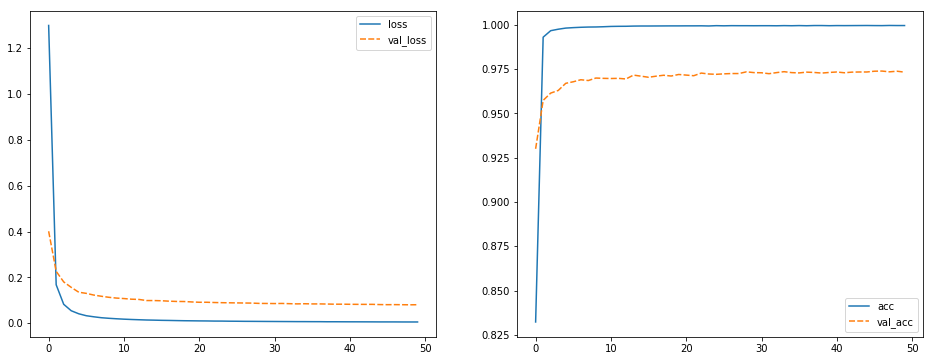

In [46]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

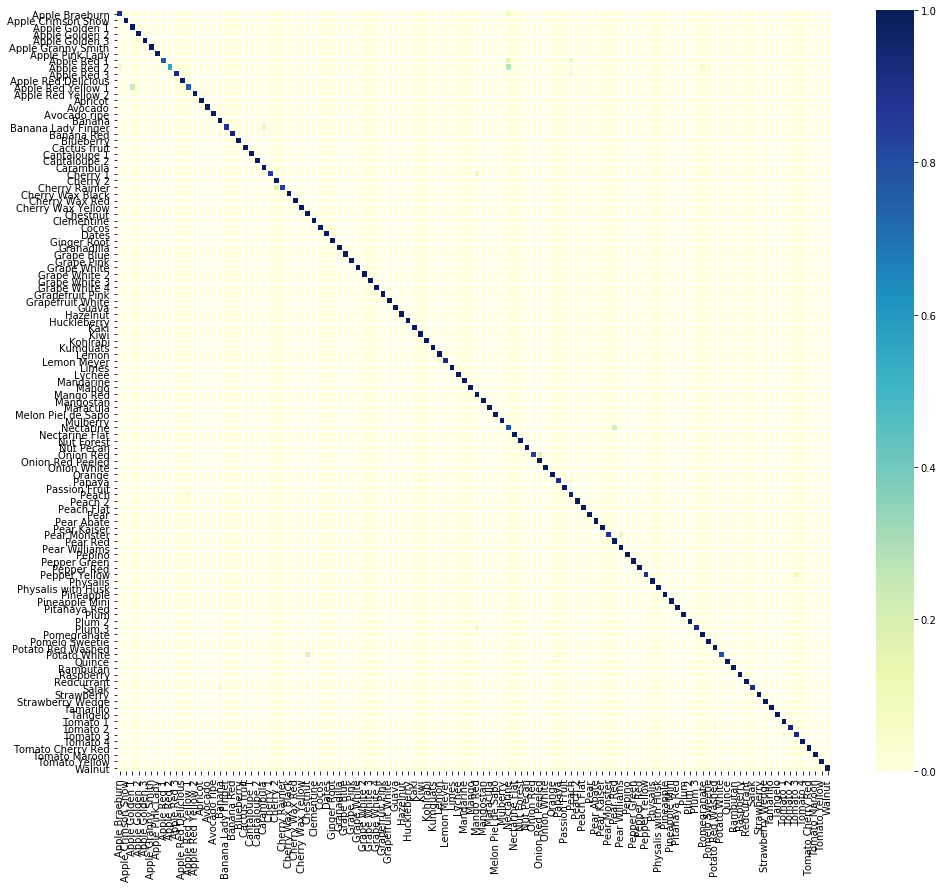

In [47]:
if os.path.isfile("VGG16_fe_epoch_" + str(epochs) + ".h5"):
    VGG16_model = load_model("VGG16_fe_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(VGG16_model, train_generator, train_steps)


predictions_validation = fazer_predicao(VGG16_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "VGG16 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["VGG16_fe_validation"] = diagonal

### Acurácia por Classe

In [48]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [49]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Mango Red,1.0
Onion White,1.0
Pepino,1.0
Pear Williams,1.0
Pear Red,1.0
Pear Kaiser,1.0
Pear Abate,1.0
Pear,1.0
Peach Flat,1.0
Peach 2,1.0


#### 10 piores

In [50]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Red 2,0.561224
Apple Red 1,0.755102
Apple Red Yellow 1,0.755102
Potato White,0.777778
Nectarine,0.785714
Onion Red,0.833333
Cherry Rainier,0.836735
Cherry 1,0.857143
Pear Monster,0.887755
Banana Lady Finger,0.888889


## Fine Tuning

In [51]:
for layer in VGG16_model.layers:
    layer.trainable = True

VGG16_model.compile(loss ='categorical_crossentropy',
                    optimizer = rms,
                    metrics=['accuracy'])

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Treinando o modelo

In [52]:
history = treinar_modelo(device, VGG16_model, train_generator, train_steps, epochs, validation_generator, patience)

VGG16_model.save("VGG16_ft_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 200s 279ms/step - loss: 15.9611 - acc: 0.0097 - val_loss: 15.9798 - val_acc: 0.0086
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 195s 272ms/step - loss: 15.9779 - acc: 0.0087 - val_loss: 15.9798 - val_acc: 0.0086
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 195s 272ms/step - loss: 15.9797 - acc: 0.0086 - val_loss: 15.9798 - val_acc: 0.0086
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 196s 273ms/step - loss: 15.9797 - acc: 0.0086 - val_loss: 15.9798 - val_acc: 0.0086
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5.000000000000001e-05.
717/717 [==============================] - 195s 272ms/ste

### Imprimindo resultado do treinamento

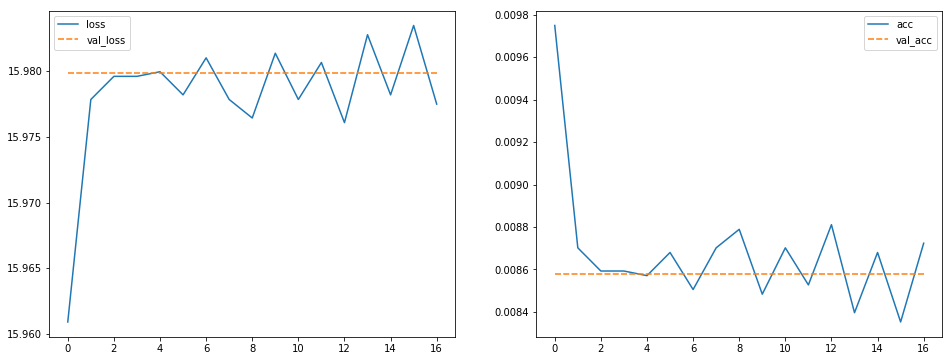

In [53]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

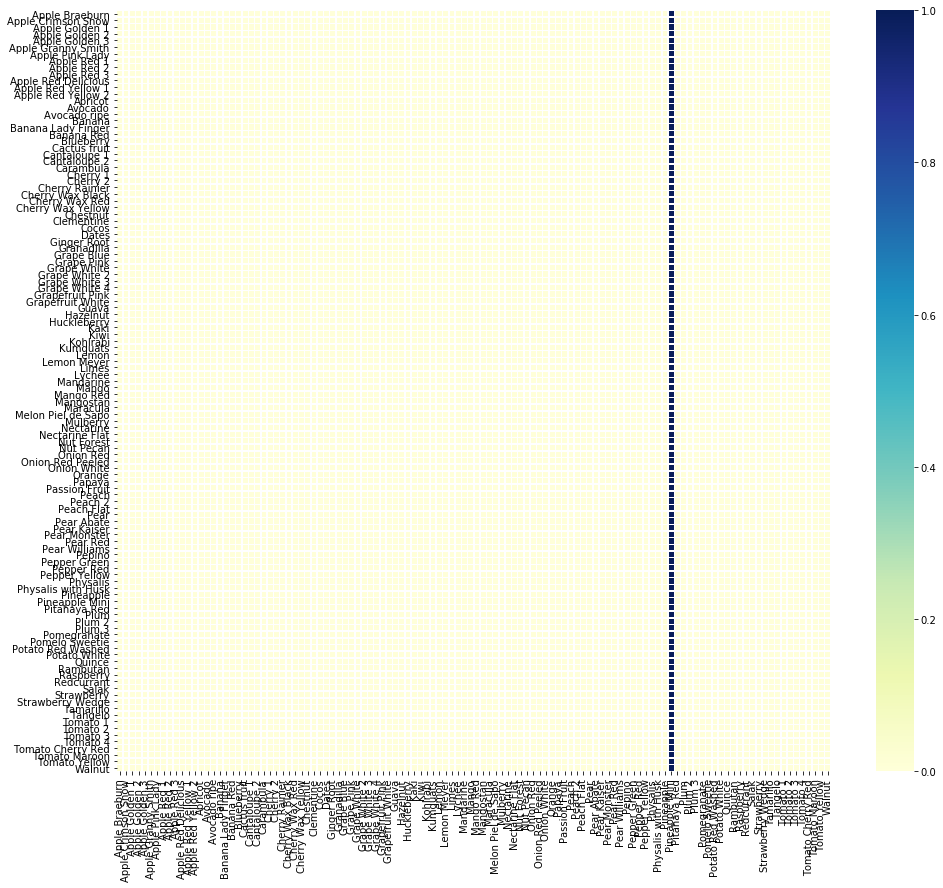

In [54]:
if os.path.isfile("VGG16_ft_epoch_" + str(epochs) + ".h5"):
    VGG16_model = load_model("VGG16_ft_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(VGG16_model, train_generator, train_steps)


predictions_validation = fazer_predicao(VGG16_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "VGG16 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["VGG16_ft_validation"] = diagonal

### Acurácia por Classe

In [55]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [56]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Pineapple Mini,1.0
Apple Braeburn,0.0
Peach,0.0
Pepper Red,0.0
Pepper Green,0.0
Pepino,0.0
Pear Williams,0.0
Pear Red,0.0
Pear Monster,0.0
Pear Kaiser,0.0


#### 10 piores

In [57]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Braeburn,0.0
Pepino,0.0
Pear Williams,0.0
Pear Red,0.0
Pear Monster,0.0
Pear Kaiser,0.0
Pear Abate,0.0
Pear,0.0
Peach Flat,0.0
Peach 2,0.0


# InceptionV3 - Transfer Learning

## Feature Extraction

In [58]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

InceptionV3_model = InceptionV3(input_shape = input_shape,
                                weights = "imagenet",
                                include_top = False)

for layer in InceptionV3_model.layers:
    layer.trainable = False

output = InceptionV3_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(units = len(classes),
               activation ='softmax',
               name = 'saida_mdc')(output)

InceptionV3_model = Model(inputs = InceptionV3_model.input,
                          outputs = output)

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Treinando o modelo

In [59]:
history = treinar_modelo(device, InceptionV3_model, train_generator, train_steps, epochs, validation_generator, patience)

InceptionV3_model.save("InceptionV3_fe_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 153s 213ms/step - loss: 3.5925 - acc: 0.3516 - val_loss: 6.1170 - val_acc: 0.0836
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 147s 205ms/step - loss: 2.3663 - acc: 0.6567 - val_loss: 6.4073 - val_acc: 0.0996E - ETA: 27s - loss:  - ETA: 25 - ETA: 23s - lo - ETA: 13s - loss: 2.3988
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 147s 205ms/step - loss: 1.9715 - acc: 0.7083 - val_loss: 6.8097 - val_acc: 0.0998
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 147s 206ms/step - loss: 1.7697 - acc: 0.7353 - val_loss: 7.0909 - val_acc: 0.0980- loss: 1. - ETA: 1:29 - loss: 1.820 - ETA: 1:26 - loss - ETA: 1:23 -  - ETA: 1:18 - los

### Imprimindo resultado do treinamento

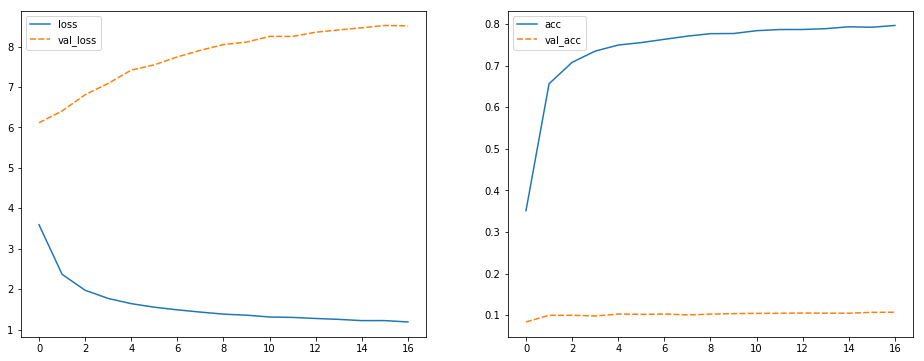

In [60]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

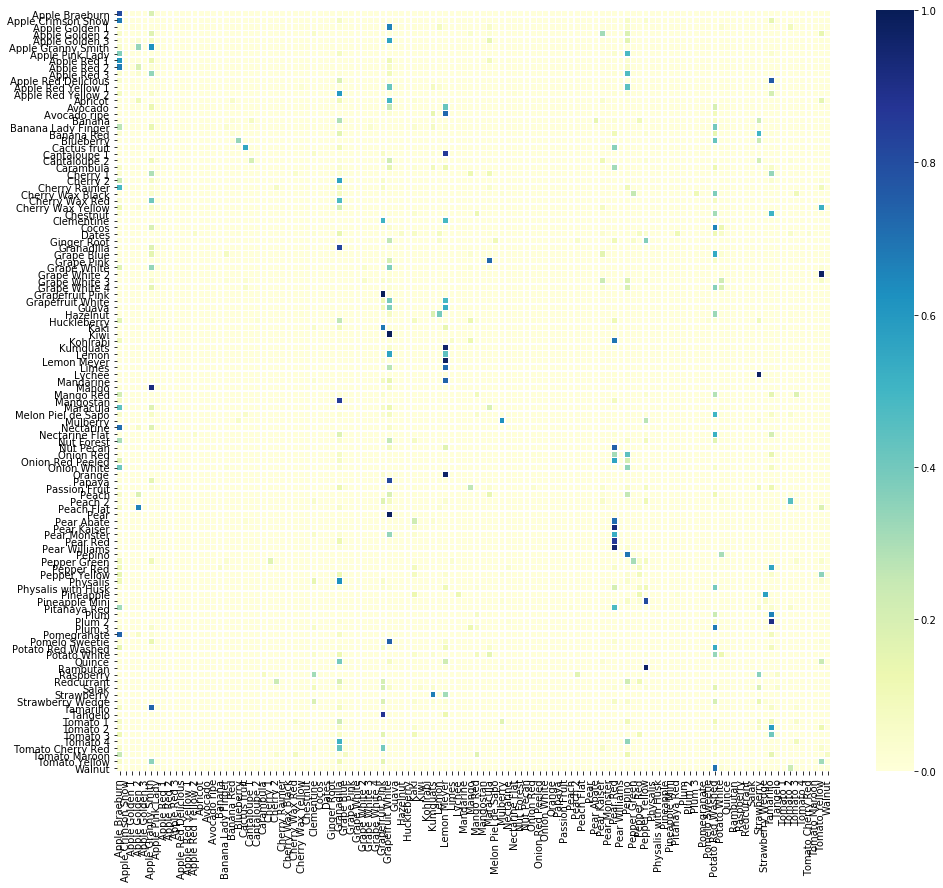

In [61]:
if os.path.isfile("InceptionV3_fe_epoch_" + str(epochs) + ".h5"):
    InceptionV3_model = load_model("InceptionV3_fe_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(InceptionV3_model, train_generator, train_steps)


predictions_validation = fazer_predicao(InceptionV3_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "InceptionV3 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["InceptionV3_fe_validation"] = diagonal

### Acurácia por Classe

In [62]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [63]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Grapefruit Pink,1.000000
Lemon Meyer,0.979592
Pear Red,0.857143
Granadilla,0.826531
Apple Braeburn,0.806122
Pepino,0.693878
Apple Granny Smith,0.622449
Mulberry,0.622449
Cactus fruit,0.551020
Potato Red Washed,0.533333


#### 10 piores

In [64]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Mango,0.0
Pear,0.0
Peach Flat,0.0
Peach 2,0.0
Peach,0.0
Passion Fruit,0.0
Papaya,0.0
Orange,0.0
Onion White,0.0
Onion Red Peeled,0.0


## Fine Tuning

In [65]:
for layer in InceptionV3_model.layers:
    layer.trainable = True

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Treinando o modelo

In [66]:
history = treinar_modelo(device, InceptionV3_model, train_generator, train_steps, epochs, validation_generator, patience)

InceptionV3_model.save("InceptionV3_ft_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 186s 259ms/step - loss: 0.1549 - acc: 0.9665 - val_loss: 0.8024 - val_acc: 0.9066
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 170s 237ms/step - loss: 0.0070 - acc: 0.9983 - val_loss: 0.0911 - val_acc: 0.9818
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 170s 237ms/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0357 - val_acc: 0.9918
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 170s 237ms/step - loss: 8.4343e-04 - acc: 0.9997 - val_loss: 0.0423 - val_acc: 0.9903
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5.000000000000001e-05.
717/717 [==============================] - 169s 236ms/step - 

### Imprimindo resultado do treinamento

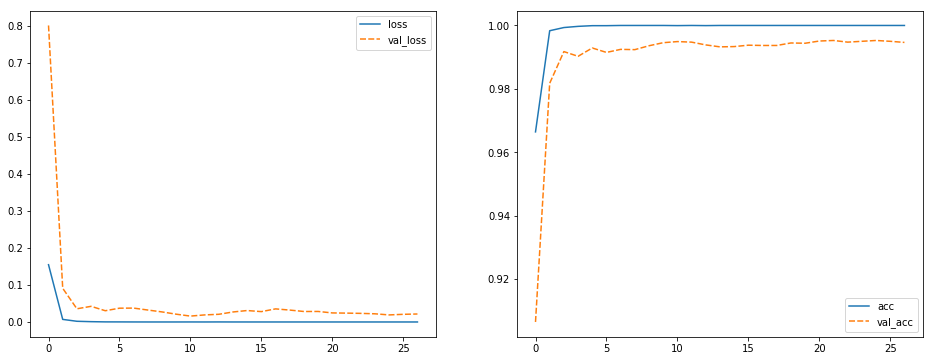

In [67]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

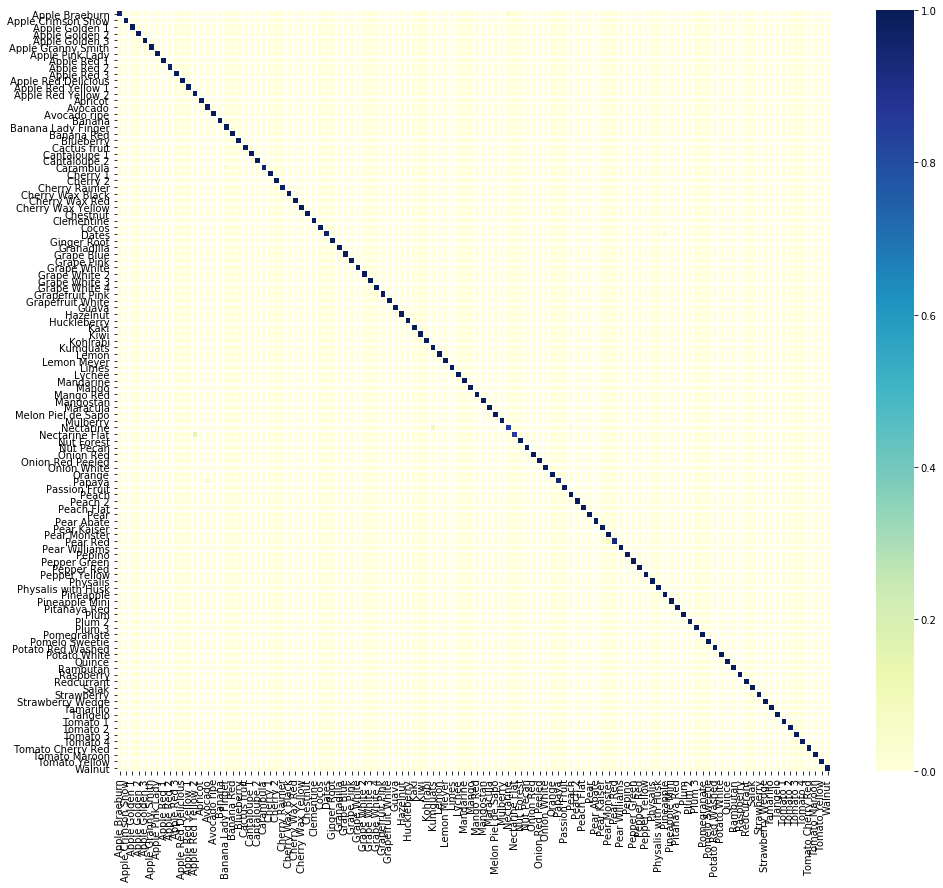

In [68]:
if os.path.isfile("InceptionV3_ft_epoch_" + str(epochs) + ".h5"):
    InceptionV3_model = load_model("InceptionV3_ft_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(InceptionV3_model, train_generator, train_steps)


predictions_validation = fazer_predicao(InceptionV3_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "InceptionV3 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["InceptionV3_ft_validation"] = diagonal

### Acurácia por Classe

In [69]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [70]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Mango Red,1.0
Peach,1.0
Pepper Yellow,1.0
Pepper Red,1.0
Pepper Green,1.0
Pepino,1.0
Pear Williams,1.0
Pear Monster,1.0
Pear Kaiser,1.0
Pear Abate,1.0


#### 10 piores

In [71]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Nectarine Flat,0.854167
Nectarine,0.867347
Pear Red,0.932331
Papaya,0.948980
Apple Braeburn,0.959184
Carambula,0.959184
Dates,0.969388
Cherry Rainier,0.972789
Apple Red 2,0.979592
Pepper Red,1.000000


# MobileNetV2 - Transfer Learning

## Feature Extraction

In [72]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

MobileNet_model = MobileNetV2(input_shape = input_shape,
                              weights = "imagenet",
                              include_top = False)

for layer in MobileNet_model.layers:
    layer.trainable = False

output = MobileNet_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(units = len(classes),
               activation ='softmax',
               name = 'saida_mdc')(output)

MobileNet_model = Model(inputs = MobileNet_model.input,
                        outputs = output)

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Treinando o modelo

In [73]:
history = treinar_modelo(device, MobileNet_model, train_generator, train_steps, epochs, validation_generator, patience)

MobileNet_model.save("MobileNet_fe_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 201s 281ms/step - loss: 0.1161 - acc: 0.9764 - val_loss: 5.3915 - val_acc: 0.1945
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
  4/717 [..............................] - ETA: 48s - loss: 3.6224e-04 - acc: 1.0000 

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101023). Check your callbacks.
  % delta_t_median)


333/717 [============>.................] - ETA: 1:30 - loss: 6.4484e-05 - acc: 1.0000

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101023). Check your callbacks.
  % delta_t_median)


717/717 [==============================] - 196s 274ms/step - loss: 5.9950e-05 - acc: 1.0000 - val_loss: 5.4016 - val_acc: 0.2054
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 217s 302ms/step - loss: 2.8288e-05 - acc: 1.0000 - val_loss: 5.3779 - val_acc: 0.2169
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 202s 281ms/step - loss: 2.2803e-05 - acc: 1.0000 - val_loss: 5.3936 - val_acc: 0.2131
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5.000000000000001e-05.
717/717 [==============================] - 198s 276ms/step - loss: 1.9814e-06 - acc: 1.0000 - val_loss: 5.4351 - val_acc: 0.2157
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to 4.1666666666666665e-05.
717/717 [==============================] - 197s 275ms/step - loss: 1.8884e-06 - acc: 1.0000 - val_loss: 5.4048 - val

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110025). Check your callbacks.
  % delta_t_median)


717/717 [==============================] - 198s 276ms/step - loss: 7.7942e-07 - acc: 1.0000 - val_loss: 5.4920 - val_acc: 0.2124
Epoch 13/50

Epoch 00013: LearningRateScheduler setting learning rate to 1.923076923076923e-05.
717/717 [==============================] - 199s 277ms/step - loss: 1.5634e-06 - acc: 1.0000 - val_loss: 5.4984 - val_acc: 0.2131
Epoch 14/50

Epoch 00014: LearningRateScheduler setting learning rate to 1.785714285714286e-05.
717/717 [==============================] - 198s 276ms/step - loss: 8.3504e-07 - acc: 1.0000 - val_loss: 5.4745 - val_acc: 0.2160
Epoch 15/50

Epoch 00015: LearningRateScheduler setting learning rate to 1.6666666666666667e-05.
717/717 [==============================] - 198s 276ms/step - loss: 9.3118e-07 - acc: 1.0000 - val_loss: 5.4650 - val_acc: 0.2159
Epoch 16/50

Epoch 00016: LearningRateScheduler setting learning rate to 1.5625e-05.
717/717 [==============================] - 198s 276ms/step - loss: 1.0249e-06 - acc: 1.0000 - val_loss: 5.4665

### Imprimindo resultado do treinamento

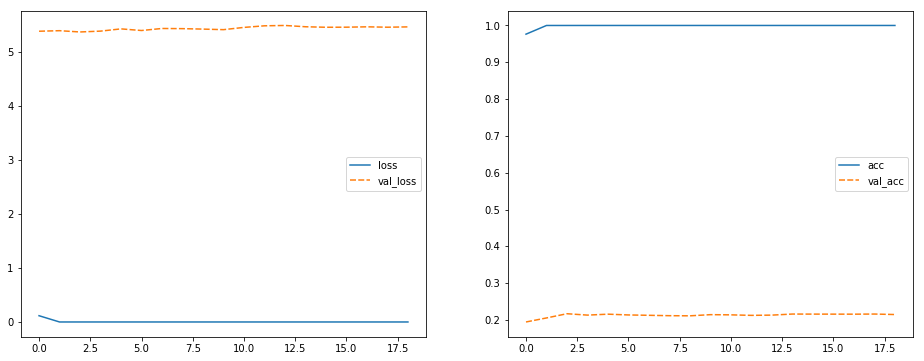

In [74]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

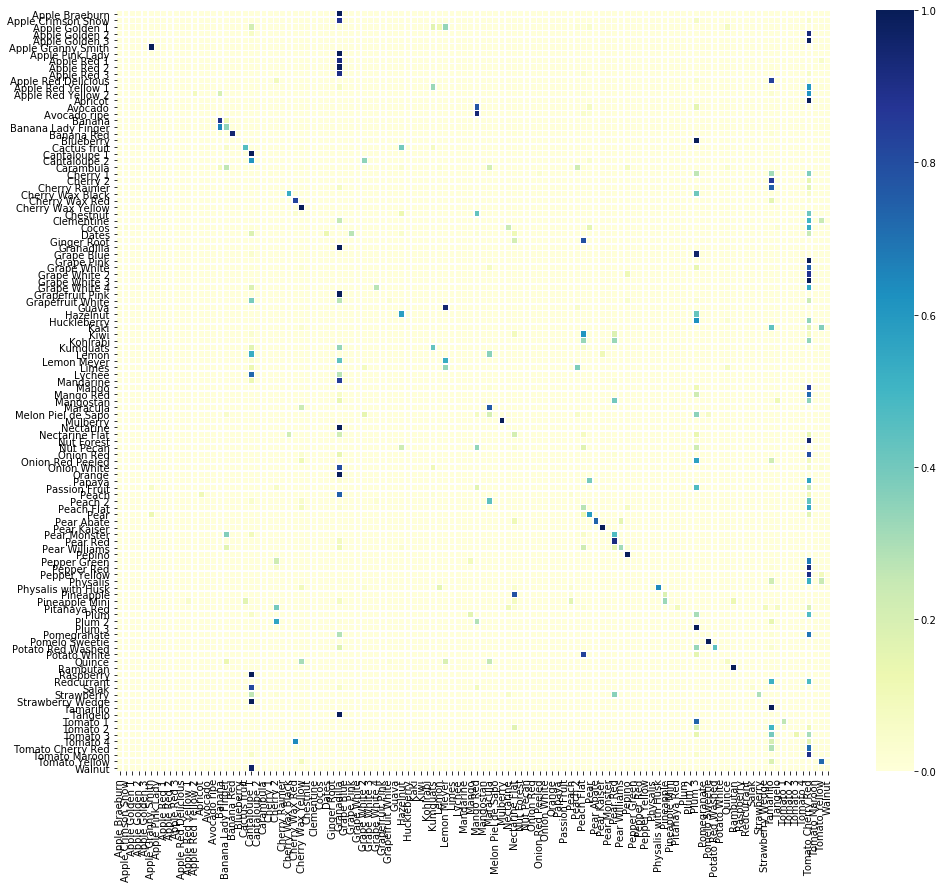

In [75]:
if os.path.isfile("MobileNet_fe_epoch_" + str(epochs) + ".h5"):
    MobileNet_model = load_model("MobileNet_fe_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(MobileNet_model, train_generator, train_steps)


predictions_validation = fazer_predicao(MobileNet_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "MobileNet - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["MobileNet_fe_validation"] = diagonal

### Acurácia por Classe

In [76]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [77]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Plum 3,1.0
Pear Kaiser,1.0
Cherry Wax Yellow,1.0
Pomelo Sweetie,1.0
Granadilla,1.0
Tamarillo,1.0
Cantaloupe 1,1.0
Mulberry,1.0
Rambutan,1.0
Apple Granny Smith,1.0


#### 10 piores

In [78]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Braeburn,0.0
Onion Red Peeled,0.0
Onion Red,0.0
Nut Pecan,0.0
Nut Forest,0.0
Nectarine,0.0
Mangostan,0.0
Mango Red,0.0
Onion White,0.0
Mandarine,0.0


## Fine Tuning

In [79]:
for layer in MobileNet_model.layers:
    layer.trainable = True

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Treinando o modelo

In [80]:
history = treinar_modelo(device, MobileNet_model, train_generator, train_steps, epochs, validation_generator, patience)

MobileNet_model.save("MobileNet_ft_epoch_" + str(epochs) + ".h5")

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.00025.
717/717 [==============================] - 230s 321ms/step - loss: 0.0251 - acc: 0.9955 - val_loss: 0.7165 - val_acc: 0.8564
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.000125.
717/717 [==============================] - 221s 308ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0742 - val_acc: 0.9831
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 8.333333333333333e-05.
717/717 [==============================] - 222s 310ms/step - loss: 4.3984e-06 - acc: 1.0000 - val_loss: 0.0225 - val_acc: 0.9924
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.25e-05.
717/717 [==============================] - 223s 311ms/step - loss: 3.0166e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9890
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5.000000000000001e-05.
717/717 [==============================] - 223s 310ms/ste

Epoch 38/50

Epoch 00038: LearningRateScheduler setting learning rate to 6.578947368421053e-06.
717/717 [==============================] - 222s 309ms/step - loss: 1.2123e-07 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9944
Epoch 39/50

Epoch 00039: LearningRateScheduler setting learning rate to 6.410256410256411e-06.
717/717 [==============================] - 222s 309ms/step - loss: 1.2055e-07 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 0.9944
Epoch 40/50

Epoch 00040: LearningRateScheduler setting learning rate to 6.250000000000001e-06.
717/717 [==============================] - 222s 309ms/step - loss: 1.1986e-07 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9944
Epoch 41/50

Epoch 00041: LearningRateScheduler setting learning rate to 6.097560975609757e-06.
717/717 [==============================] - 222s 309ms/step - loss: 1.2048e-07 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9943
Epoch 42/50

Epoch 00042: LearningRateScheduler setting learning rate to 5.952380952380953e-06.
717/

### Imprimindo resultado do treinamento

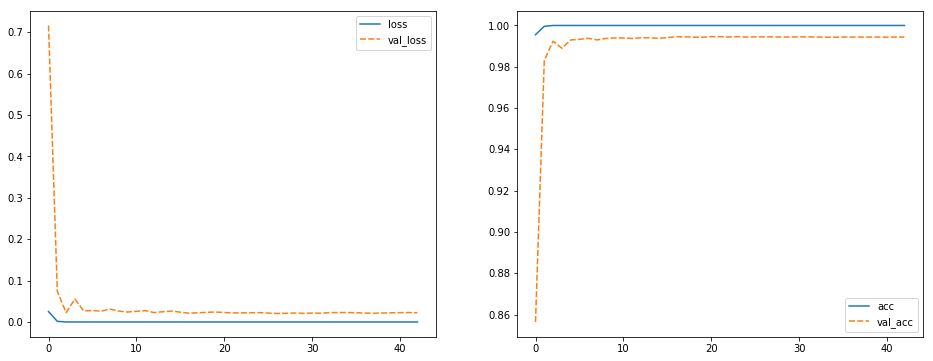

In [81]:
imprimir_resultado_treinamento(history)

## Matriz de Confusão & Acurácia

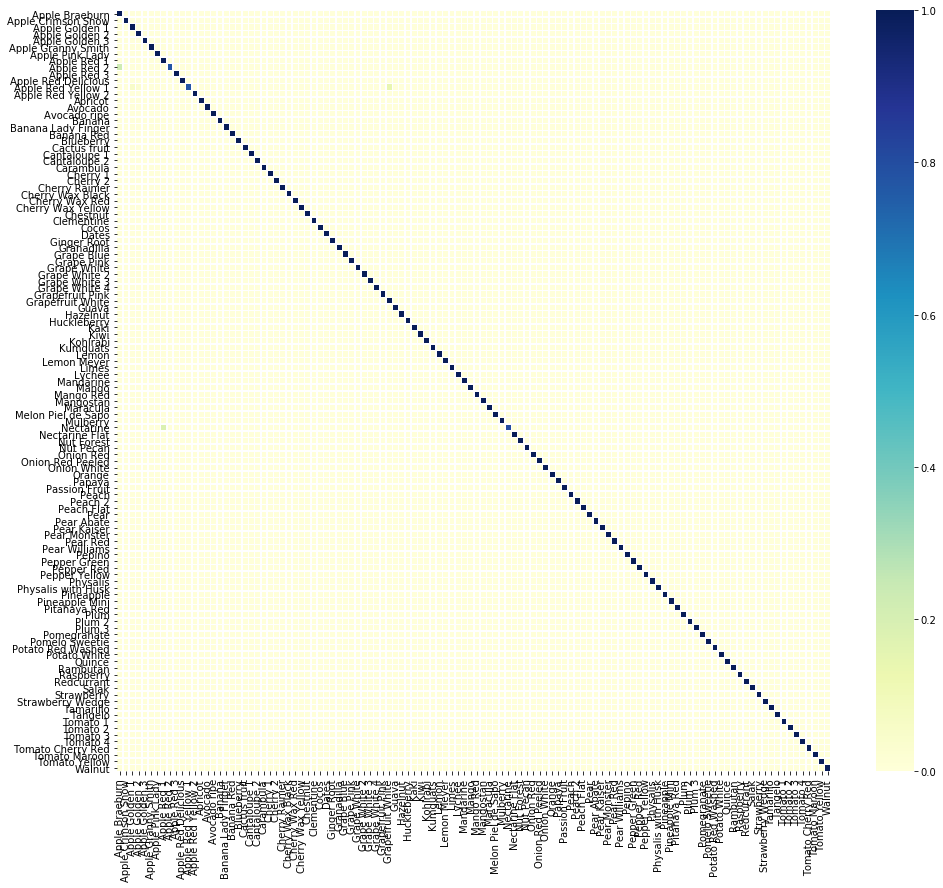

In [82]:
if os.path.isfile("MobileNet_ft_epoch_" + str(epochs) + ".h5"):
    MobileNet_model = load_model("MobileNet_ft_epoch_" + str(epochs) + ".h5")

score_train = avaliar_modelo(MobileNet_model, train_generator, train_steps)


predictions_validation = fazer_predicao(MobileNet_model, validation_generator, validation_steps)

score_val = accuracy_score(validation_generator.classes, predictions_validation)


df_resultado = salvar_resultado(rede = "MobileNet - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val,
                                df = df_resultado)

diagonal = imprimir_matriz_confusao(predictions_validation, validation_generator.classes)

acuracias["MobileNet_ft_validation"] = diagonal

### Acurácia por Classe

In [83]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [84]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Apple Braeburn,1.0
Apple Crimson Snow,1.0
Pepper Yellow,1.0
Pepper Red,1.0
Pepper Green,1.0
Pepino,1.0
Pear Williams,1.0
Pear Red,1.0
Pear Monster,1.0
Pear Kaiser,1.0


#### 10 piores

In [85]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Apple Red 2,0.775510
Apple Red Yellow 1,0.775510
Nectarine,0.806122
Apple Braeburn,1.000000
Pepper Red,1.000000
Pepper Green,1.000000
Pepino,1.000000
Pear Williams,1.000000
Pear Red,1.000000
Pear Monster,1.000000


# Imprimindo o resultado dos modelos - Base de Treino e Validação

In [86]:
df_resultado.sort_values(by=["val_acc"])

,Rede,train_acc,val_acc
1,ResNet50 - Feature Extraction,0.006456,0.008403
4,VGG16 - Fine Tuning,0.008658,0.008578
5,InceptionV3 - Feature Extraction,0.080803,0.083596
7,MobileNet - Feature Extraction,0.237961,0.216912
0,Homemade,0.999542,0.923319
3,VGG16 - Feature Extraction,0.999629,0.973302
2,ResNet50 - Fine Tuning,0.998735,0.988445
8,MobileNet - Fine Tuning,1.000000,0.994485
6,InceptionV3 - Fine Tuning,1.000000,0.994923


# Teste estatístico: comparando os dois algoritmos sobre o conjunto de validação

In [90]:
results = {}
results["MobileNet"] = pd.DataFrame({"val_acc": acuracias["MobileNet_ft_validation"]})
results["InceptionV3"] = pd.DataFrame({"val_acc": acuracias["InceptionV3_ft_validation"]})

In [91]:
from scipy import stats
s, p = stats.wilcoxon(*(r["val_acc"] for r in results.values()))
print("p-valor:", p)

p-valor: 0.798731419934417


In [100]:
dif_acc = results["InceptionV3"].val_acc.mean() - results["MobileNet"].val_acc.mean()

print("A rede \'InceptionV3 - Fine Tuning\' apresentou melhor resultado (", dif_acc * 100.0,"% pontos acima) comparado com a rede \'MobileNet - Fine Tuning\'.")
print("O p-valor = ",p," indica que essa diferença não é significativa.")

A rede 'InceptionV3 - Fine Tuning' apresentou melhor resultado ( 0.07527826458376685 % pontos acima) comparado com a rede MobileNet - Fine Tuning.
O p-valor =  0.798731419934417  indica que essa diferença não é significativa.


In [113]:
results = {}
results["MobileNet"] = pd.DataFrame({"val_acc": acuracias["MobileNet_ft_validation"]})
results["VGG16"] = pd.DataFrame({"val_acc": acuracias["VGG16_fe_validation"]})

In [114]:
from scipy import stats
s, p = stats.wilcoxon(*(r["val_acc"] for r in results.values()))
print("p-valor:", p)

p-valor: 1.816160646059112e-05


In [117]:
dif_acc = results["MobileNet"].val_acc.mean() - results["VGG16"].val_acc.mean()

print("A rede \'MobileNet - Fine Tuning\' apresentou melhor resultado (", dif_acc * 100.0,"% pontos acima) comparado com a rede \'VGG16 - Feature Extraction\'.")
print("O p-valor = ",p," indica que essa diferença é significativa.")

A rede 'MobileNet - Fine Tuning' apresentou melhor resultado ( 2.0047590655313696 % pontos acima) comparado com a rede 'VGG16 - Feature Extraction'.
O p-valor =  1.816160646059112e-05  indica que essa diferença é significativa.


# Aplicando o melhor modelo na base de Teste

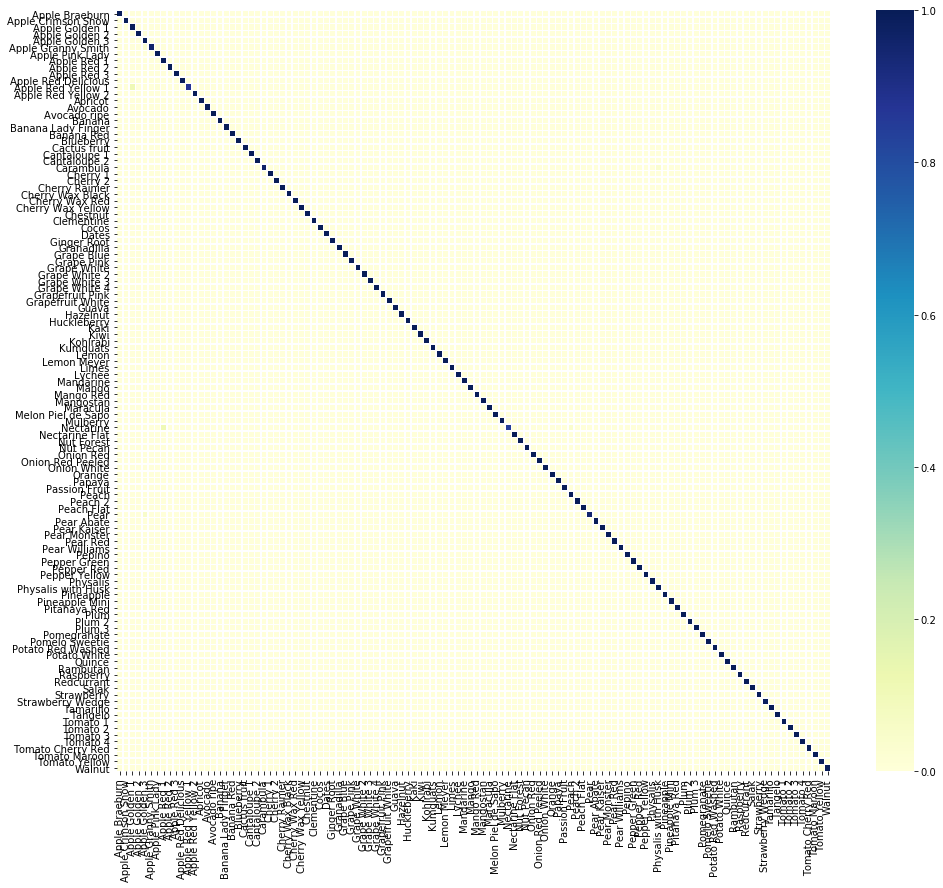

In [92]:
best_model = load_model("MobileNet_ft_epoch_50.h5")

predictions_test = fazer_predicao(best_model, test_generator, test_steps)

score_test = accuracy_score(test_generator.classes, predictions_test)

diagonal = imprimir_matriz_confusao(predictions_test, test_generator.classes)

In [93]:
print("Acurácia na base de Teste: ", score_test)

Acurácia na base de Teste:  0.996316758747698


### Acurácia por Classe

In [94]:
acc_classes = pd.DataFrame({"Acurácia" : diagonal})
acc_classes.index = classes

#### 10 melhores

In [95]:
acc_classes.sort_values(by=["Acurácia"], ascending=False).head(10)

,Acurácia
Mango Red,1.0
Papaya,1.0
Pepper Red,1.0
Pepper Green,1.0
Pear Williams,1.0
Pear Red,1.0
Pear Monster,1.0
Pear Kaiser,1.0
Pear Abate,1.0
Peach Flat,1.0


#### 10 piores

In [96]:
acc_classes.sort_values(by=["Acurácia"]).head(10)

,Acurácia
Nectarine,0.847561
Apple Red Yellow 1,0.878049
Pear,0.951220
Apple Granny Smith,0.963415
Carambula,0.963855
Strawberry Wedge,0.987805
Banana Lady Finger,0.993421
Apple Braeburn,0.993902
Apple Golden 1,0.993902
Pepino,0.993976


#### Classes que não alcançaram 100% de acurácia

In [108]:
acc_menor = acc_classes[acc_classes["Acurácia"] < 1.0].sort_values(by=["Acurácia"])

In [109]:
acc_menor["classes"] = acc_menor.index

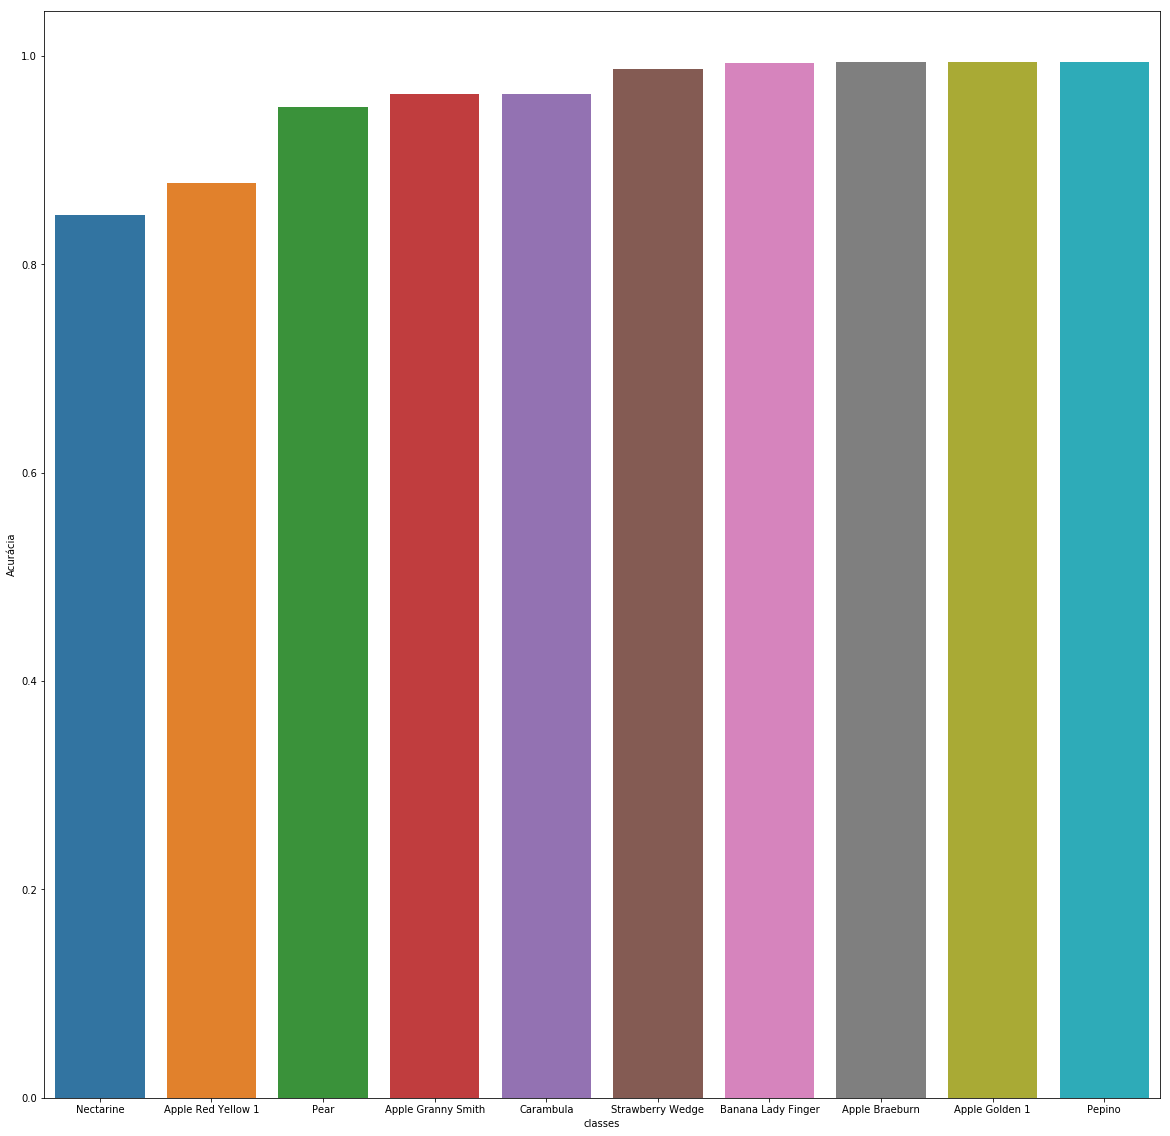

In [111]:
g=sns.barplot(x = "classes",y = "Acurácia", data = acc_menor)

#### Lista completa

In [97]:
acc_classes.sort_values(by=["Acurácia"])

,Acurácia
Nectarine,0.847561
Apple Red Yellow 1,0.878049
Pear,0.951220
Apple Granny Smith,0.963415
Carambula,0.963855
Strawberry Wedge,0.987805
Banana Lady Finger,0.993421
Apple Braeburn,0.993902
Apple Golden 1,0.993902
Pepino,0.993976
